<a href="https://colab.research.google.com/github/42bismuth/Alzheimer-Detection/blob/main/nlp/Naive_Bayes_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import spacy
import numpy as np
import glob
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC


import sys

In [4]:
df = pd.read_csv('/content/data/cookie_tagged.csv', sep = ';')
df.head()

,label,sentence,text,pos_text,pos_,pos_text_complete,pos_complete,new_text,text_for_POS
0,0,"[""the boy is on a stool that is falling while ...",the boy is on a stool that is falling while he...,the DET boy NOUN is AUX on ADP a DET stool NOU...,DET NOUN AUX ADP DET NOUN PRON AUX VERB SCONJ ...,the determiner boy noun is auxiliary on adposi...,determiner noun auxiliary adposition determine...,the boy is on a stool that is falling while he...,the boy is on a stool that is falling while he...
1,0,"['oh I remember this one . [+ exc] ', 'okay . ...",oh I remember this one . [+ exc] okay . [+ ex...,oh INTJ I PRON remember VERB this DET one NOUN...,INTJ PRON VERB DET NOUN PUNCT X CCONJ X X SPAC...,oh interjection I pronoun remember verb this d...,interjection pronoun verb determiner noun punc...,oh I remember this one . okay . the mom's ...,oh I remember this one . okay . the mom's ...
2,1,"['the sink is running over . ', ""and &-uh the ...",the sink is running over . and &-uh the [/] t...,the DET sink NOUN is AUX running VERB over ADV...,DET NOUN AUX VERB ADV PUNCT SPACE CCONJ CCONJ ...,the determiner sink noun is auxiliary running ...,determiner noun auxiliary verb adverb punctuat...,the sink is running over . and -uh the [ repe...,the sink is running over . and -uh the the l...
3,0,"['the woman is wiping the dishes . ', ""she's s...",the woman is wiping the dishes . she's standi...,the DET woman NOUN is AUX wiping VERB the DET ...,DET NOUN AUX VERB DET NOUN PUNCT SPACE PRON AU...,the determiner woman noun is auxiliary wiping ...,determiner noun auxiliary verb determiner noun...,the woman is wiping the dishes . she's standi...,the woman is wiping the dishes . she's standi...
4,1,['&-uh a boy is &-uh puttin(g) somethin(g) in ...,&-uh a boy is &-uh puttin(g) somethin(g) in th...,& CCONJ -uh INTJ a DET boy NOUN is AUX & CCONJ...,CCONJ INTJ DET NOUN AUX CCONJ PROPN PROPN PUNC...,& Cconjunction -uh interjection a determiner b...,Cconjunction interjection determiner noun auxi...,-uh a boy is -uh puttin [ incomplete_word ] so...,-uh a boy is -uh puttin somethin in the clos...


In [5]:
len(df)

549

## NBSVM

See https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline

Prepare the data frame

In [6]:
df['control'] = df.apply(lambda x: 1 if x['label'] == 0 else 0, axis = 1 )
df['dementia'] = df.apply(lambda x: 1 if x['label'] == 1 else 0, axis = 1 )
df.head()

,label,sentence,text,pos_text,pos_,pos_text_complete,pos_complete,new_text,text_for_POS,control,dementia
0,0,"[""the boy is on a stool that is falling while ...",the boy is on a stool that is falling while he...,the DET boy NOUN is AUX on ADP a DET stool NOU...,DET NOUN AUX ADP DET NOUN PRON AUX VERB SCONJ ...,the determiner boy noun is auxiliary on adposi...,determiner noun auxiliary adposition determine...,the boy is on a stool that is falling while he...,the boy is on a stool that is falling while he...,1,0
1,0,"['oh I remember this one . [+ exc] ', 'okay . ...",oh I remember this one . [+ exc] okay . [+ ex...,oh INTJ I PRON remember VERB this DET one NOUN...,INTJ PRON VERB DET NOUN PUNCT X CCONJ X X SPAC...,oh interjection I pronoun remember verb this d...,interjection pronoun verb determiner noun punc...,oh I remember this one . okay . the mom's ...,oh I remember this one . okay . the mom's ...,1,0
2,1,"['the sink is running over . ', ""and &-uh the ...",the sink is running over . and &-uh the [/] t...,the DET sink NOUN is AUX running VERB over ADV...,DET NOUN AUX VERB ADV PUNCT SPACE CCONJ CCONJ ...,the determiner sink noun is auxiliary running ...,determiner noun auxiliary verb adverb punctuat...,the sink is running over . and -uh the [ repe...,the sink is running over . and -uh the the l...,0,1
3,0,"['the woman is wiping the dishes . ', ""she's s...",the woman is wiping the dishes . she's standi...,the DET woman NOUN is AUX wiping VERB the DET ...,DET NOUN AUX VERB DET NOUN PUNCT SPACE PRON AU...,the determiner woman noun is auxiliary wiping ...,determiner noun auxiliary verb determiner noun...,the woman is wiping the dishes . she's standi...,the woman is wiping the dishes . she's standi...,1,0
4,1,['&-uh a boy is &-uh puttin(g) somethin(g) in ...,&-uh a boy is &-uh puttin(g) somethin(g) in th...,& CCONJ -uh INTJ a DET boy NOUN is AUX & CCONJ...,CCONJ INTJ DET NOUN AUX CCONJ PROPN PROPN PUNC...,& Cconjunction -uh interjection a determiner b...,Cconjunction interjection determiner noun auxi...,-uh a boy is -uh puttin [ incomplete_word ] so...,-uh a boy is -uh puttin somethin in the clos...,0,1


In [7]:
import re, string
from sklearn.linear_model import LogisticRegression

In [8]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [9]:
lens = train.text.str.len()
lens.mean(), lens.std(), lens.max()

(663.6104783599089, 334.9344664034003, 2695)

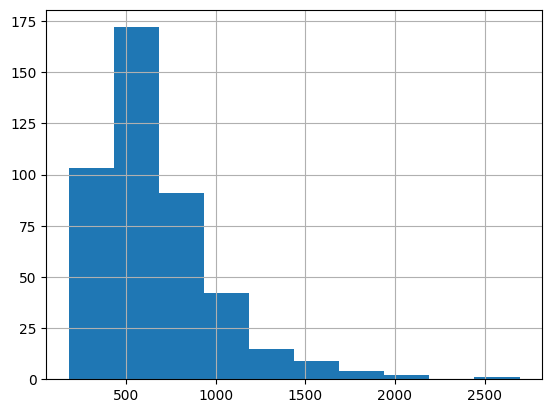

In [11]:
lens.hist();

In [10]:
label_cols = ['control', 'dementia']

In [12]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [13]:
TEXT = 'pos_text_complete'

def docs_for_column(column):
    n = train.shape[0]
    vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
    trn_term_doc = vec.fit_transform(train[column])
    test_term_doc = vec.transform(test[column])
    return trn_term_doc, test_term_doc

trn_term_doc, test_term_doc = docs_for_column(TEXT)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [14]:
trn_term_doc, test_term_doc

(<439x3586 sparse matrix of type '<class 'numpy.float64'>'
 	with 110011 stored elements in Compressed Sparse Row format>,
 <110x3586 sparse matrix of type '<class 'numpy.float64'>'
 	with 26344 stored elements in Compressed Sparse Row format>)

Here's the basic naive bayes feature equation:

In [15]:
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

Use our vectorized documents as input.

In [16]:
x = trn_term_doc
test_x = test_term_doc

Fit a model for one dependent at a time:

In [17]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    #m = LogisticRegression(C=4, dual=True)
    m = LogisticRegression(C=12, dual=False, solver='lbfgs', class_weight='balanced')
    #m = LogisticRegression(C=1, dual=True, solver='liblinear')
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [18]:
preds = np.zeros((len(test), len(label_cols)))

for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

fit control
fit dementia


In [19]:
y_hat = preds[:,1] > preds[:,0]   # bools
y_hat = [int(x) for x in y_hat]   # ints

In [22]:
print(metrics.classification_report(test['label'], y_hat))

              precision    recall  f1-score   support

           0       0.83      0.84      0.83        51
           1       0.86      0.85      0.85        59

    accuracy                           0.85       110
   macro avg       0.84      0.85      0.84       110
weighted avg       0.85      0.85      0.85       110



In [24]:
print(metrics.accuracy_score(test['label'], y_hat))

0.8454545454545455


### Repeat same thing for the clean text column

In [26]:
TEXT = 'text_for_POS'
trn_term_doc, test_term_doc = docs_for_column(TEXT)

x = trn_term_doc
test_x = test_term_doc

preds = np.zeros((len(test), len(label_cols)))
for i, j in enumerate(label_cols):
    print('fit', j)
    m,r = get_mdl(train[j])
    preds[:,i] = m.predict_proba(test_x.multiply(r))[:,1]

y_hat = preds[:,1] > preds[:,0]   # bools
y_hat = [int(x) for x in y_hat]   # ints

print(metrics.classification_report(test['label'], y_hat))
print(metrics.accuracy_score(test['label'], y_hat))

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


fit control
fit dementia
              precision    recall  f1-score   support

           0       0.79      0.88      0.83        51
           1       0.89      0.80      0.84        59

    accuracy                           0.84       110
   macro avg       0.84      0.84      0.84       110
weighted avg       0.84      0.84      0.84       110

0.8363636363636363


-------------